### UNSUPERVISED MACHINE LEARNING FOR THE CLASSIFICATION OF ASTROPHYSICAL X-RAY SOURCES

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.spatial.distance import euclidean, cdist
from scipy.special import softmax
import matplotlib.pyplot as plt

In [2]:
sim_data = pd.read_csv('gmm6_allvar_0_simbad.csv')

In [3]:
sim_df = sim_data[['col1', 'name', 'main_type', 'cluster', 'prob_0', 'prob_1', 'prob_2', 'prob_3', 'prob_4', 'prob_5']]
prob_cols = ['prob_0', 'prob_1', 'prob_2', 'prob_3', 'prob_4', 'prob_5']

In [4]:
sim_df_clean = sim_data.copy().fillna({'main_type': 'NaN'})

In [5]:
features = ['theta', 'src_area_b', 'hard_hm', 'hard_hs', 'hard_ms', 'powlaw_gamma', 'bb_kt', 'var_prob_b','var_sigma_b', 'var_mean_b', 'var_min_b', 'var_max_b', 'var_prob_h', 'var_sigma_h', 'var_mean_h', 'var_min_h', 'var_max_h', 'var_prob_m', 'var_sigma_m', 'var_mean_m', 'var_min_m', 'var_max_m', 'var_prob_s', 'var_sigma_s',
'var_mean_s', 'var_min_s', 'var_max_s', 'ks_prob_b', 'ks_prob_h', 'ks_prob_m', 'ks_prob_s', 'kp_prob_b', 'kp_prob_h', 'kp_prob_m', 'kp_prob_s']

features_lognorm = ['theta', 'src_area_b', 'bb_kt', 'var_sigma_b', 'var_mean_b', 'var_min_b', 'var_max_b', 'var_sigma_h', 'var_mean_h', 'var_min_h', 'var_max_h', 'var_sigma_m', 'var_mean_m', 'var_min_m', 'var_max_m',  'var_sigma_s', 'var_mean_s', 'var_min_s', 'var_max_s']

features_norm = ['powlaw_gamma']

X = sim_df_clean.copy().to_numpy()

In [6]:
# FUNCTION lognorm
# Apply log transform adding the minimum non-zero value divided by ten in order to preserve zero properties, then normalize.
# INPUT:
# X_df = data array
# X = data array as np array
# name_desc = string, name of the descriptor
# log = boolean, True if apply log transform before norm

# PROCEDURE:
# Modifies X np array of data with the normalizated data
def lognorm(X_df, X, name_desc, log):
    
    col = X_df.columns.get_loc(name_desc)
    X_desc = X_df[name_desc]
    
    if log:
        nonzero = X_desc[X_desc!=0]
        minval = np.min(nonzero)/10

        # print(minval)
        X_desc = X_desc + minval

        x = np.log(X_desc.values)  #returns a numpy array
    else:
        x = X_desc.to_numpy()
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
    X[:,col] = x_scaled.flatten()
    
    return X

In [7]:
# Log transformation

for feature in features_lognorm:
    X = lognorm(sim_df_clean, X, feature, True)
        
for feature in features_norm:
    X = lognorm(sim_df_clean, X, feature, False)

In [8]:
s_df = pd.DataFrame(X, columns=sim_df_clean.columns)

In [9]:
def create_summary_tables(df):
    data_n = df.copy()
    count_obs = data_n.groupby(['main_type']).size()
    df_n = pd.concat([count_obs], axis=1)
    df_n = df_n.rename(columns={0:'size'})
    return df_n

def softmin(x):
    return np.exp(-np.abs(x))/sum(np.exp(-np.abs(x)))

# Use abs with cosine metric
def frequent_types(df, n, uks):
    if uks:
        df = df[(df.main_type != 'NaN') & ~(df.main_type.isin(uks))]
    else:
        df = df[df.main_type != 'NaN']
    count_obs = df.groupby(['main_type']).size()
    count_obs_df = count_obs.reset_index()
    count_obs_df = count_obs_df.rename(columns={0:'size'})
    quer = count_obs_df.sort_values(by='size', ascending=False).head(n)
    ltypes = np.unique(quer.main_type)
    return ltypes

def gen_nan_probs(cl, features, uks=[], mean=True):
    if uks:
        cl_nan = cl[(cl.main_type == 'NaN') | cl.main_type.isin(uks)]
    else:
        cl_nan = cl[cl.main_type == 'NaN']

    cl_types_desc = cl_nan[features]
    ltypes = frequent_types(cl, 5, uks=uks)
    types_comp = []
    types_prob = []
    for i, row in cl_types_desc.iterrows():
        r_np = row.to_numpy().reshape(1, -1)

        mdists = []
        for t in ltypes:
            cl_type = cl[cl.main_type == t]
            cl_type_desc = cl_type[features]
            cltd_np = cl_type_desc.to_numpy()
            d2t = cdist(r_np, cltd_np, metric='mahalanobis')
            if mean:
                d2t_mean = np.mean(d2t)
            else:
                d2t_mean = np.median(d2t)

            mdists.append(d2t_mean)

        scaler = MinMaxScaler()
        mdistsn = np.asarray(mdists).reshape(-1, 1)
        #mdistsn = scaler.fit_transform(mdistsn)
        mdistsn = mdistsn.ravel()
        sm_probs = softmin(mdistsn)
        types_prob.append(sm_probs)
        t_amax = np.argmax(sm_probs)
        types_comp.append(ltypes[t_amax])

    #print(cl_nan.name.to_numpy(), np.array(types_prob), types_comp)
    out_l = pd.DataFrame(cl_nan[['name', 'obsid'] + features])
    out_l['main_type'] = types_comp
    for i, t in enumerate(ltypes):
        tarray_probs = np.vstack(types_prob)
        out_l[t] = tarray_probs[:, i]
        
    return out_l

In [10]:
n = 0
uks = ['Star', 'X', 'Unknown']
cl_n = s_df[s_df.cluster == n]
cl_n_nans = gen_nan_probs(cl_n, features, uks=uks, mean=False)
#cl_n_nans.head(10)

In [11]:
create_summary_tables(cl_n_nans)

,size
main_type,
BYDra,31
Candidate_YSO,198
Orion_V*,143
TTau*,72
YSO,213


```
cl_n_nans.to_csv('mahalanobis_labeled/cl{}_median.csv'.format(n))
```

In [15]:
def get_spa_plot(original_df, new_labels_df, main_type, features, method='mean'):
    n_labeled = new_labels_df[new_labels_df.main_type == main_type][features]
    n_labeled = n_labeled.to_numpy(dtype='float')

    o_labeled = original_df[original_df.main_type == main_type][features]
    o_labeled = o_labeled.to_numpy(dtype='float')

    size_desc = n_labeled.shape[1]
    mean_nlab = np.mean(n_labeled, axis=0)

    plt.figure(figsize=(15, 15))
    plt.title(main_type)
    plt.violinplot(o_labeled, showmeans=True)
    if method=='mean':
        plt.plot(np.arange(1,size_desc+1), mean_nlab, color='darkred', marker = 'o',
                markersize=10, linewidth=3, label='New labeled sources')
    elif method=='all':
        for i in range(size_desc-20):
            plt.plot(np.arange(1,size_desc+1), n_labeled[i])
    plt.legend()
    plt.show()

def all_types_plot(original_df, new_labels_df, features, method='mean'):
    labels_nl = list(np.unique(new_labels_df.main_type))
    uks = ['Star', 'X', 'Unknown']
    labels_ol = frequent_types(original_df, 5, uks=uks)

    size_desc = len(features)
    
    lab_nl = []
    for i, label in enumerate(labels_nl):
        nl_lab = new_labels_df[new_labels_df.main_type == label][features]
        nl_lab_np = nl_lab.to_numpy(dtype='float')
        mean_nlab = np.mean(nl_lab_np, axis=0)
        lab_nl.append(mean_nlab)
    lab_nl_np = np.vstack(lab_nl)

    lab_ol = []
    for i, label in enumerate(labels_ol):
        nl_lab = original_df[original_df.main_type == label][features]
        nl_lab_np = nl_lab.to_numpy(dtype='float')
        mean_nlab = np.mean(nl_lab_np, axis=0)
        lab_ol.append(mean_nlab)
    lab_ol_np = np.vstack(lab_ol)

    cs = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:cyan']
    fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('New labeled'.format(np.unique(original_df.cluster)[0]))
    ax2.set_title('Original labeled'.format(np.unique(original_df.cluster)[0]))
    if method=='mean':
        for i, label in enumerate(labels_nl):
            ax1.plot(features, lab_nl_np[i,:], color=cs[i],
                     marker='o', markersize=6, label=label)
            ax1.legend(loc="best")
            ax1.set_xticks(features)
            ax1.set_xticklabels(features, rotation='vertical')
            ax1.set_ylim(-0.5, 1)

        for i, label in enumerate(labels_ol):
            if label in labels_nl:
                idx = labels_nl.index(label)
                ax2.plot(features, lab_ol_np[i,:], color=cs[idx],
                         marker='o', markersize=6, label=label)
            else:
                idx = -1
                ax2.plot(features, lab_ol_np[i,:], color=cs[idx],
                         marker='o', markersize=6, label=label)
                cs.pop(-1)

            ax2.legend(loc="best")
            ax2.set_xticks(features)
            ax2.set_ylim(-0.5, 1)
            ax2.set_xticklabels(features, rotation='vertical')


    elif method=='median':
        return True
    
    plt.savefig('plots/cl{}_mean.png'.format(np.unique(original_df.cluster)[0]), facecolor='white')
    plt.show()
    

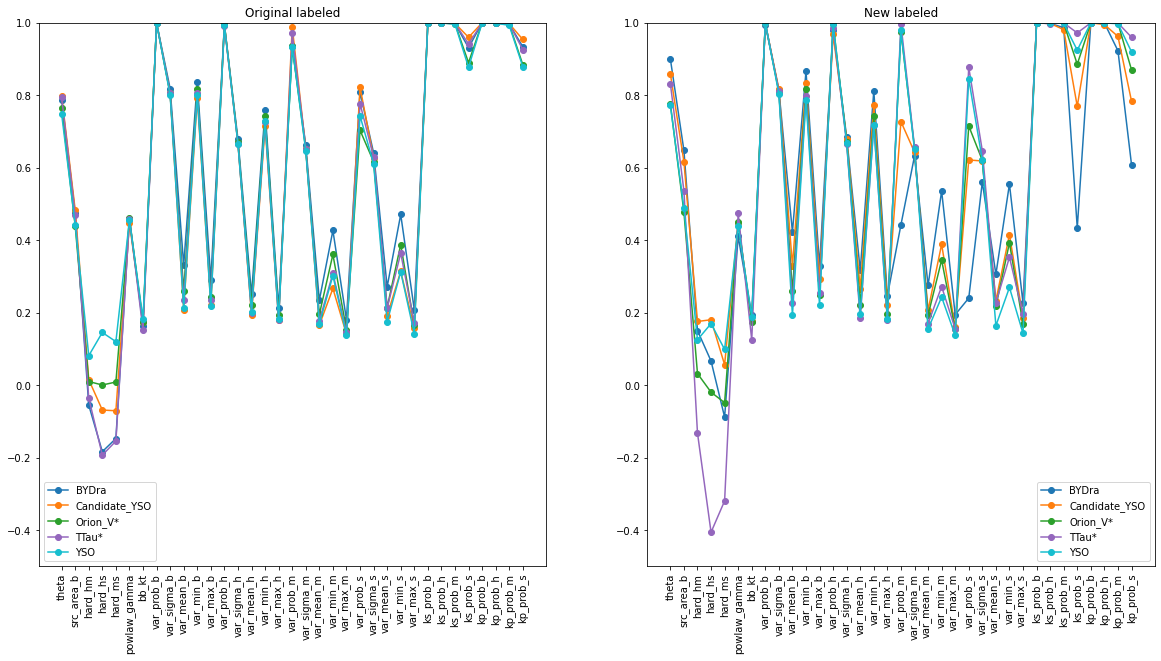

In [16]:
all_types_plot(cl_n, cl_n_nans, features, method='mean')

C:\Users\samue\miniconda3\envs\astrox\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\samue\miniconda3\envs\astrox\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


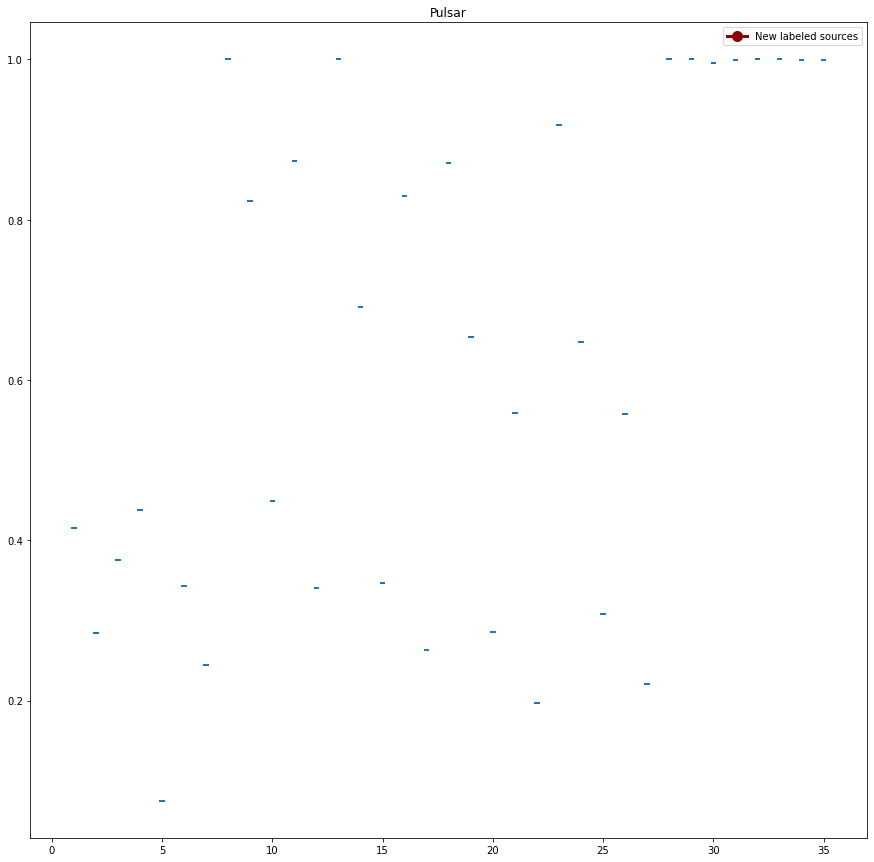

In [14]:
get_spa_plot(cl_n, cl_n_nans, 'Pulsar', features, method='mean')